# PowerCo Project - Churn Rate Analysis and Prediction
Hypothesis: Investigate whether price sensitivity is the most influential factor for a customer churning.
I went through the 5-step methodology of:
* Business understanding and problem framing.
* Exploratory data analysis and data cleaning
* Feature engineering
* Modeling and evaluation
* Insights and recommendations

In [2]:
#Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline

### About Data:
* Price contains all the prices for each time range(peak, mid_peak, off_peak) for each respective client company.
* Client data contains historical data of the client which serves as the features of the client and finally a churn column that acts as an indicator whether the customer churned or not.

In [3]:
# Import CSV file
price = pd.read_csv('price_data (1).csv')
client = pd.read_csv('client_data (1).csv')

In [3]:
client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              14606 non-null  object 
 1   channel_sales                   14606 non-null  object 
 2   cons_12m                        14606 non-null  int64  
 3   cons_gas_12m                    14606 non-null  int64  
 4   cons_last_month                 14606 non-null  int64  
 5   date_activ                      14606 non-null  object 
 6   date_end                        14606 non-null  object 
 7   date_modif_prod                 14606 non-null  object 
 8   date_renewal                    14606 non-null  object 
 9   forecast_cons_12m               14606 non-null  float64
 10  forecast_cons_year              14606 non-null  int64  
 11  forecast_discount_energy        14606 non-null  float64
 12  forecast_meter_rent_12m         

In [9]:
client.describe().map(lambda x: f"{x:0.2f}").transpose()

,count,mean,std,min,25%,50%,75%,max
cons_12m,14606.00,159220.29,573465.26,0.00,5674.75,14115.50,40763.75,6207104.00
cons_gas_12m,14606.00,28092.38,162973.06,0.00,0.00,0.00,0.00,4154590.00
cons_last_month,14606.00,16090.27,64364.20,0.00,0.00,792.50,3383.00,771203.00
forecast_cons_12m,14606.00,1868.61,2387.57,0.00,495.00,1112.88,2401.79,82902.83
forecast_cons_year,14606.00,1399.76,3247.79,0.00,0.00,314.00,1745.75,175375.00
forecast_discount_energy,14606.00,0.97,5.11,0.00,0.00,0.00,0.00,30.00
forecast_meter_rent_12m,14606.00,63.09,66.17,0.00,16.18,18.80,131.03,599.31
forecast_price_energy_off_peak,14606.00,0.14,0.02,0.00,0.12,0.14,0.15,0.27
forecast_price_energy_peak,14606.00,0.05,0.05,0.00,0.00,0.08,0.10,0.20
forecast_price_pow_off_peak,14606.00,43.13,4.49,0.00,40.61,44.31,44.31,59.27


In [10]:
price.describe().map(lambda x: f"{x:0.2f}").transpose()

,count,mean,std,min,25%,50%,75%,max
price_off_peak_var,193002.00,0.14,0.03,0.00,0.13,0.15,0.15,0.28
price_peak_var,193002.00,0.05,0.05,0.00,0.00,0.09,0.10,0.23
price_mid_peak_var,193002.00,0.03,0.04,0.00,0.00,0.00,0.07,0.11
price_off_peak_fix,193002.00,43.33,5.41,0.00,40.73,44.27,44.44,59.44
price_peak_fix,193002.00,10.62,12.84,0.00,0.00,0.00,24.34,36.49
price_mid_peak_fix,193002.00,6.41,7.77,0.00,0.00,0.00,16.23,17.46


* There's presence of wrong datatype in the date related columns.
* It appears that there is a lot of outliers in the client dataset which will be dealt with in the feature engineering section of this project.

## Data Exploration and Cleaning

churn
0    0.902848
1    0.097152
Name: proportion, dtype: float64


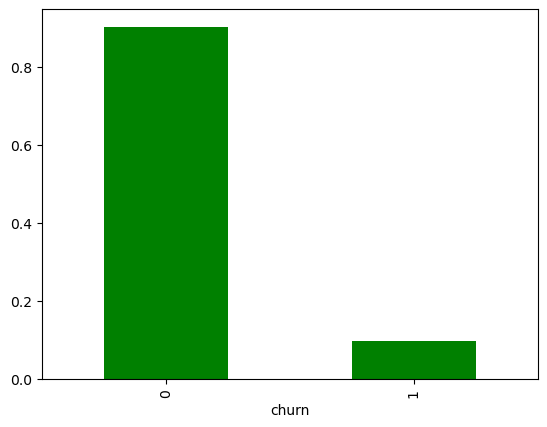

In [4]:
print(client["churn"].value_counts(normalize = True));
client["churn"].value_counts(normalize = True).plot(kind = "bar", color = "green");

#Approxiamtely 10 percent of client churned during the date period present in dataset

In [6]:
#Group data into different group to focus on trends in each column
cons = client[['id','cons_12m', 'cons_gas_12m', 'has_gas', 'cons_last_month','imp_cons','churn']]
forecast = client[['id','forecast_cons_12m', 'forecast_cons_year', 'forecast_discount_energy','forecast_meter_rent_12m',
                   'forecast_price_energy_off_peak','forecast_price_energy_peak', 'forecast_price_pow_off_peak','churn']]
subs = client[['id','margin_gross_pow_ele', 'margin_net_pow_ele', 'pow_max','churn']]
dates = client[['id','date_activ', 'date_end', 'date_modif_prod', 'date_renewal',"churn"]]
other = client[['id','num_years_antig','net_margin','channel_sales','has_gas','churn']]

#### Exploring Others(channel_sales, num_years_antig, and net_margin)

<Axes: xlabel='channel_sales'>

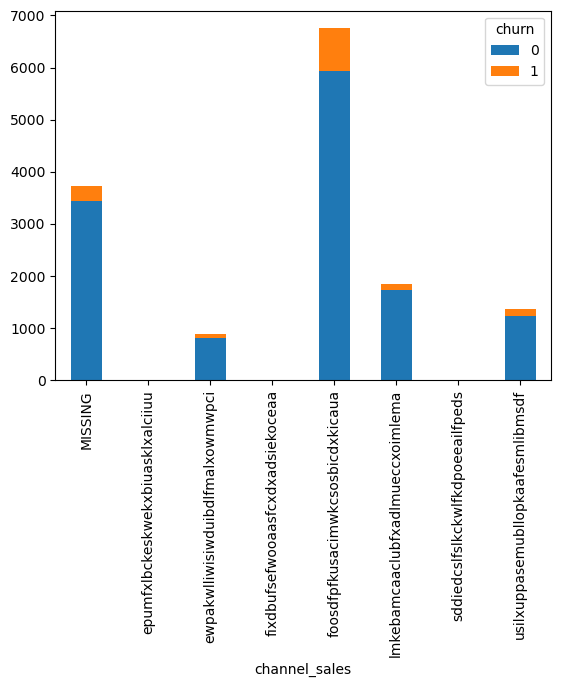

In [16]:
other.groupby([other["channel_sales"], other["churn"]])["id"].count().unstack(level = 1).fillna(0).plot(kind = "bar", stacked = True, )

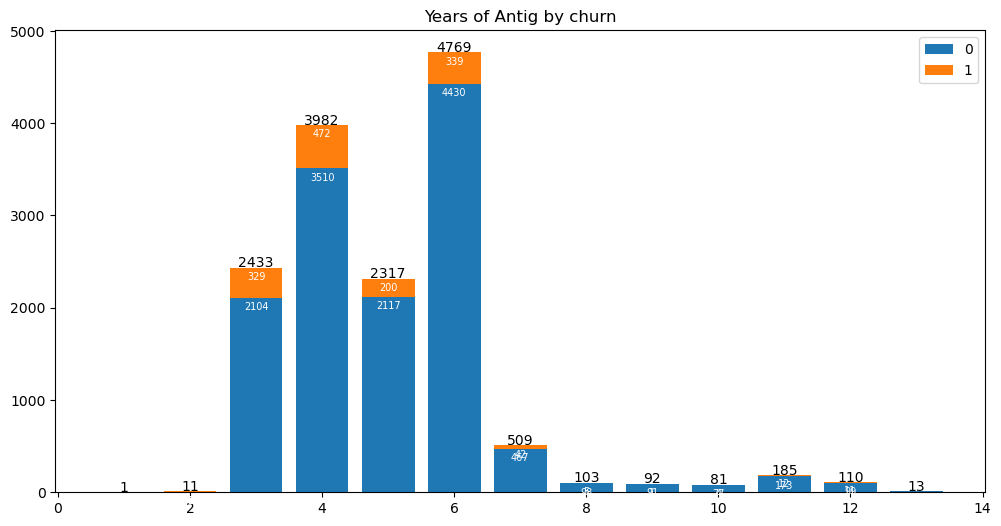

In [11]:
antig = other.groupby([other["num_years_antig"], other["churn"]])["id"].count().unstack().fillna(0)

fig,ax = plt.subplots(figsize =(12,6))
bottom = np.zeros(len(antig))
for i, col in enumerate(antig.columns):
    ax.bar(antig.index, antig[col], bottom = bottom, label = col)
    bottom += np.array(antig[col])
totals = antig.sum(axis = 1)
y_offset = 4
for i, total in enumerate(totals):
    ax.text(totals.index[i], total+y_offset, round(total), ha = "center")

y_offset = -100
for bar in ax.patches:
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + bar.get_y() + y_offset, 
        round(bar.get_height()),
        ha = "center",
        va = "center",
        color = "w",
        fontsize = 7
    )
ax.set_title("Years of Antig by churn")
ax.legend()

<Axes: xlabel='has_gas'>

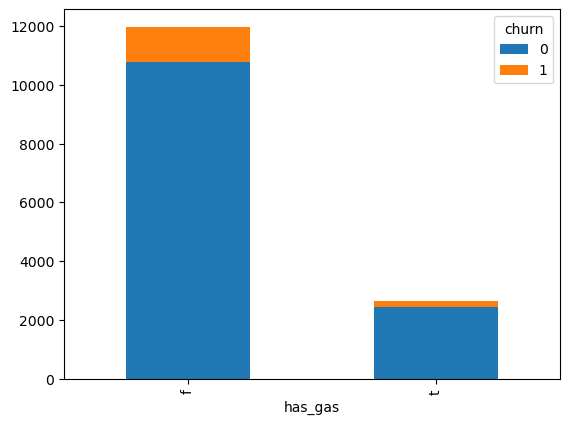

In [52]:
# Has_gas analysis
hg = client.groupby([client["has_gas"],client["churn"]])["id"].count().unstack()
hg.plot(kind = "bar", stacked = True)

<Axes: ylabel='Frequency'>

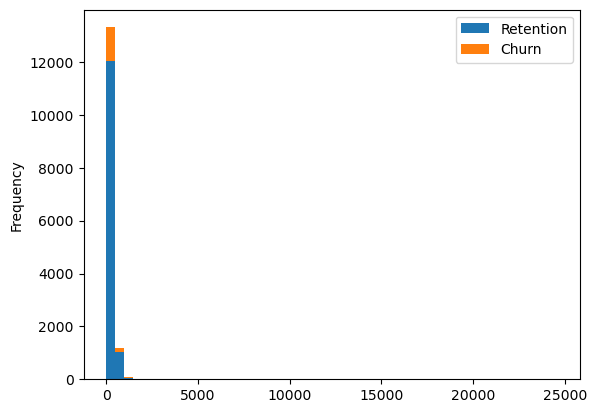

In [73]:
net_margin = pd.DataFrame({"Retention":other[other["churn"]==0]["net_margin"],
                           "Churn":other[other["churn"]==1]["net_margin"]})
net_margin[["Retention","Churn"]].plot(kind = "hist", bins = 50, stacked = True)
#Presence of Outliers

#### Exploring Cons( cons_12m, cons_gas_12m, cons_last_month, imp_cons)

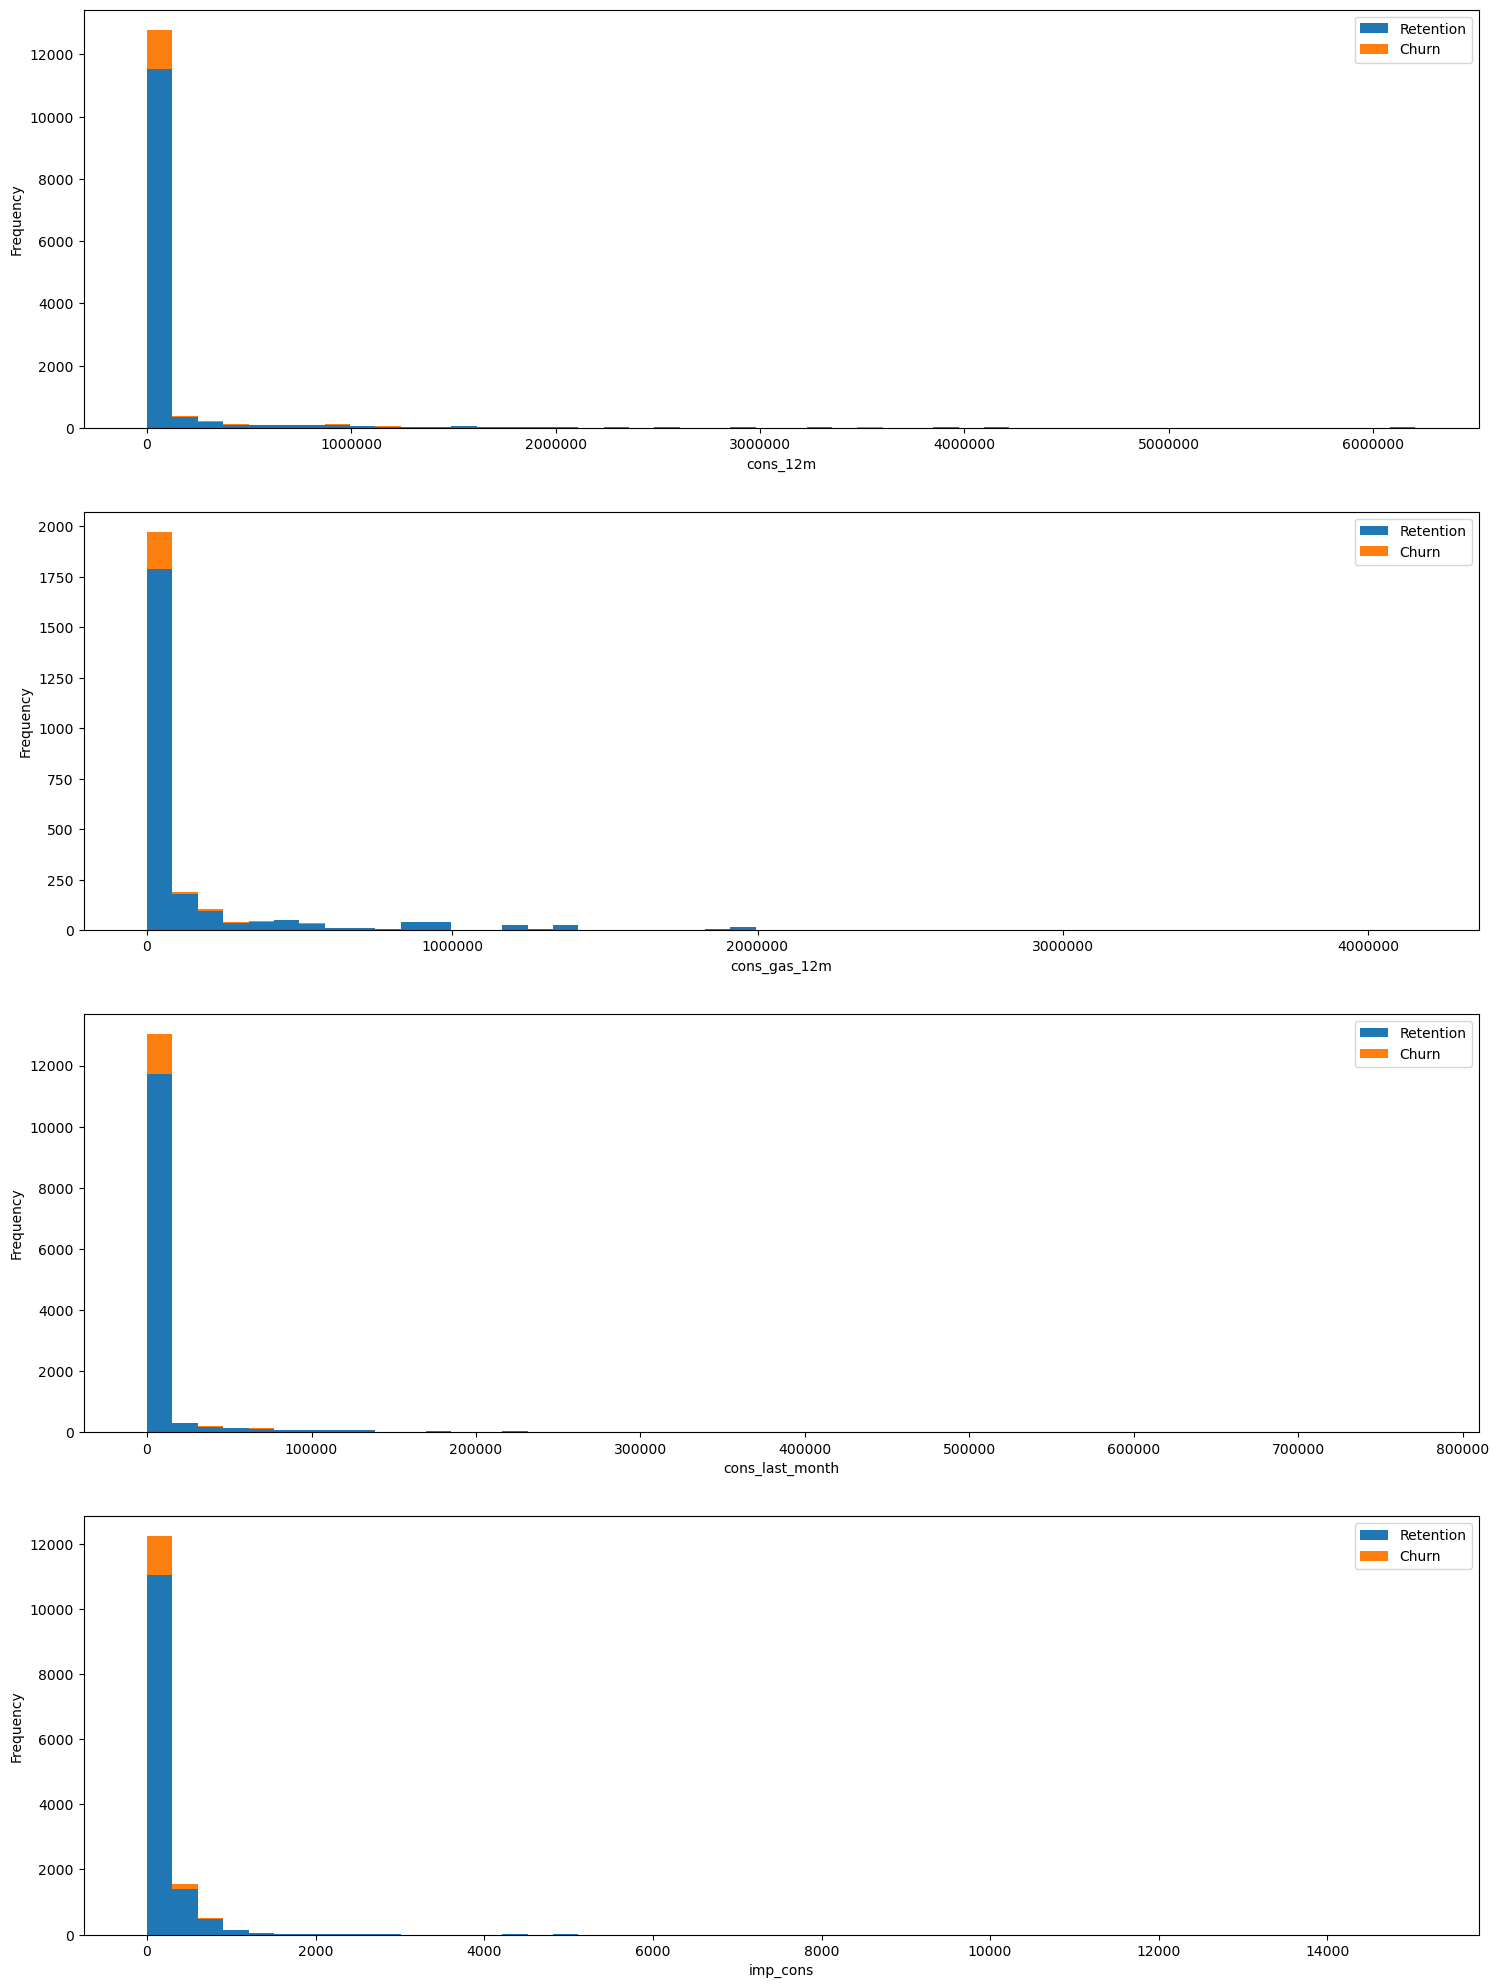

In [76]:
def plot_distribution(dataframe, column, ax, bins_=50):
    #Plot variable distribution in a stacked histogram of churned or retained company

    temp = pd.DataFrame({"Retention": dataframe[dataframe["churn"]==0][column],
    "Churn":dataframe[dataframe["churn"]==1][column]})
    # Plot the histogram
    temp[["Retention","Churn"]].plot(kind='hist', bins=bins_, ax=ax, stacked=True)
    # X-axis label
    ax.set_xlabel(column)
    # Change the x-axis to plain style
    ax.ticklabel_format(style='plain', axis='x')


fig, axs = plt.subplots(nrows=4, figsize=(18, 25))
plot_distribution(cons, 'cons_12m', axs[0])
plot_distribution(cons[cons['has_gas'] == 't'], 'cons_gas_12m', axs[1])
plot_distribution(cons, 'cons_last_month', axs[2])
plot_distribution(cons, 'imp_cons', axs[3])

#### Exploring Forecasts

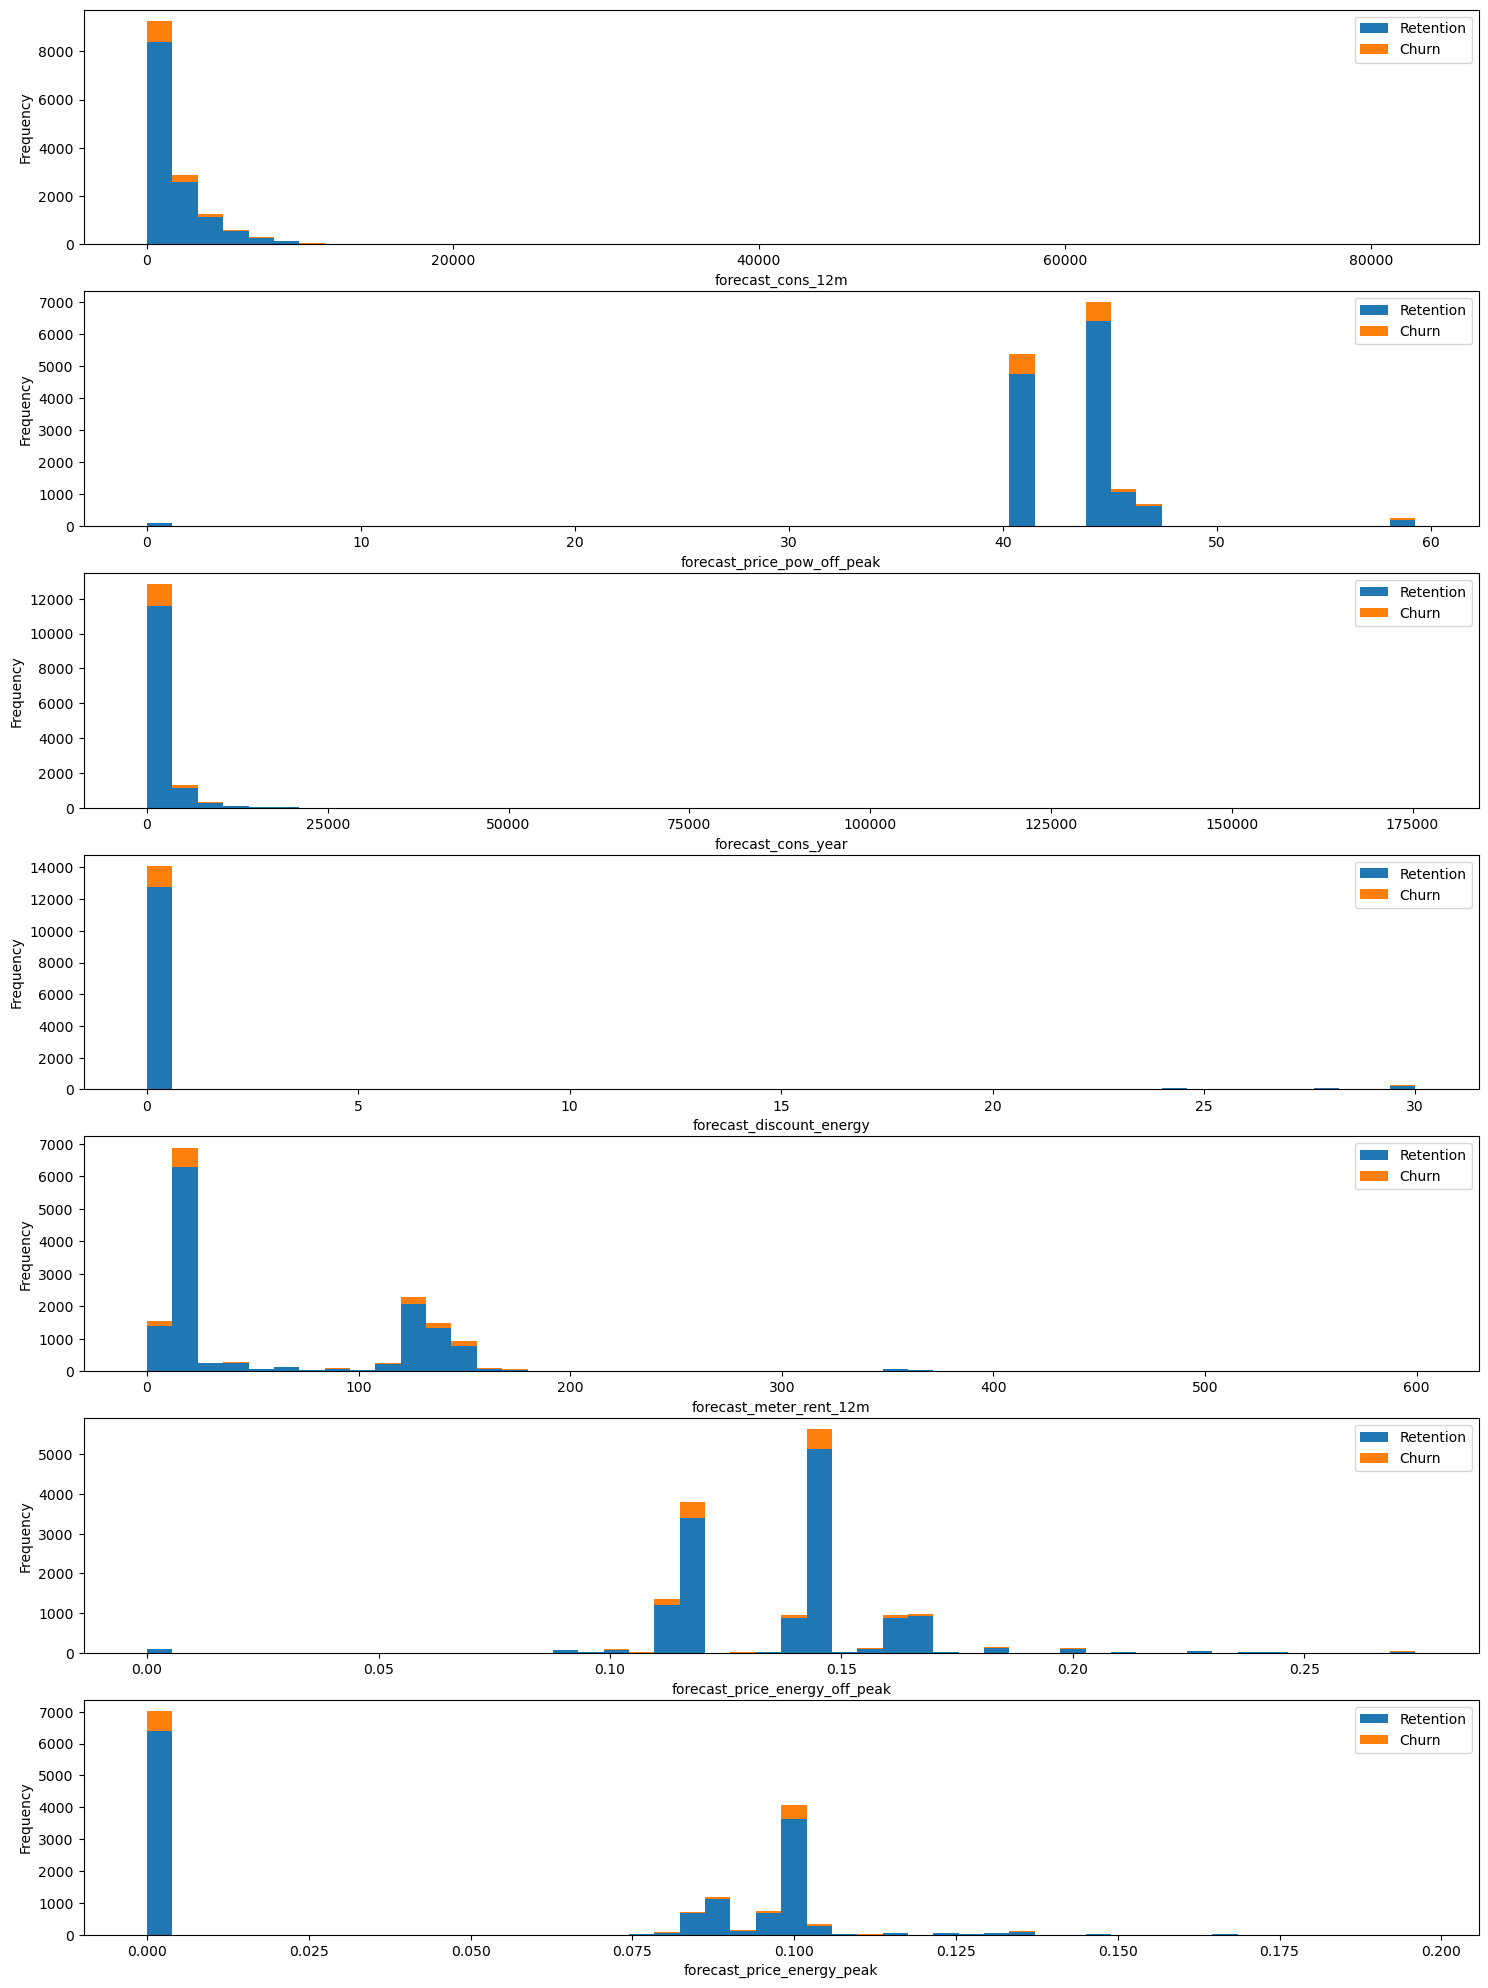

In [78]:
def plot_distribution(dataframe, column, ax, bins_=50):
    #Plot variable distribution in a stacked histogram of churned or retained company

    temp = pd.DataFrame({"Retention": dataframe[dataframe["churn"]==0][column],
    "Churn":dataframe[dataframe["churn"]==1][column]})
    # Plot the histogram
    temp[["Retention","Churn"]].plot(kind='hist', bins=bins_, ax=ax, stacked=True)
    # X-axis label
    ax.set_xlabel(column)
    # Change the x-axis to plain style
    ax.ticklabel_format(style='plain', axis='x')


fig, axs = plt.subplots(nrows=7, figsize=(18, 25))
plot_distribution(forecast, 'forecast_cons_12m', axs[0])
plot_distribution(forecast, 'forecast_price_pow_off_peak', axs[1])
plot_distribution(forecast, 'forecast_cons_year', axs[2])
plot_distribution(forecast, 'forecast_discount_energy', axs[3])
plot_distribution(forecast, 'forecast_meter_rent_12m', axs[4])
plot_distribution(forecast, 'forecast_price_energy_off_peak', axs[5])
plot_distribution(forecast, 'forecast_price_energy_peak', axs[6])

#### Exploring Subs(Margin_gross_pow_ele, Margin_net_pow_ele, Pow_max)

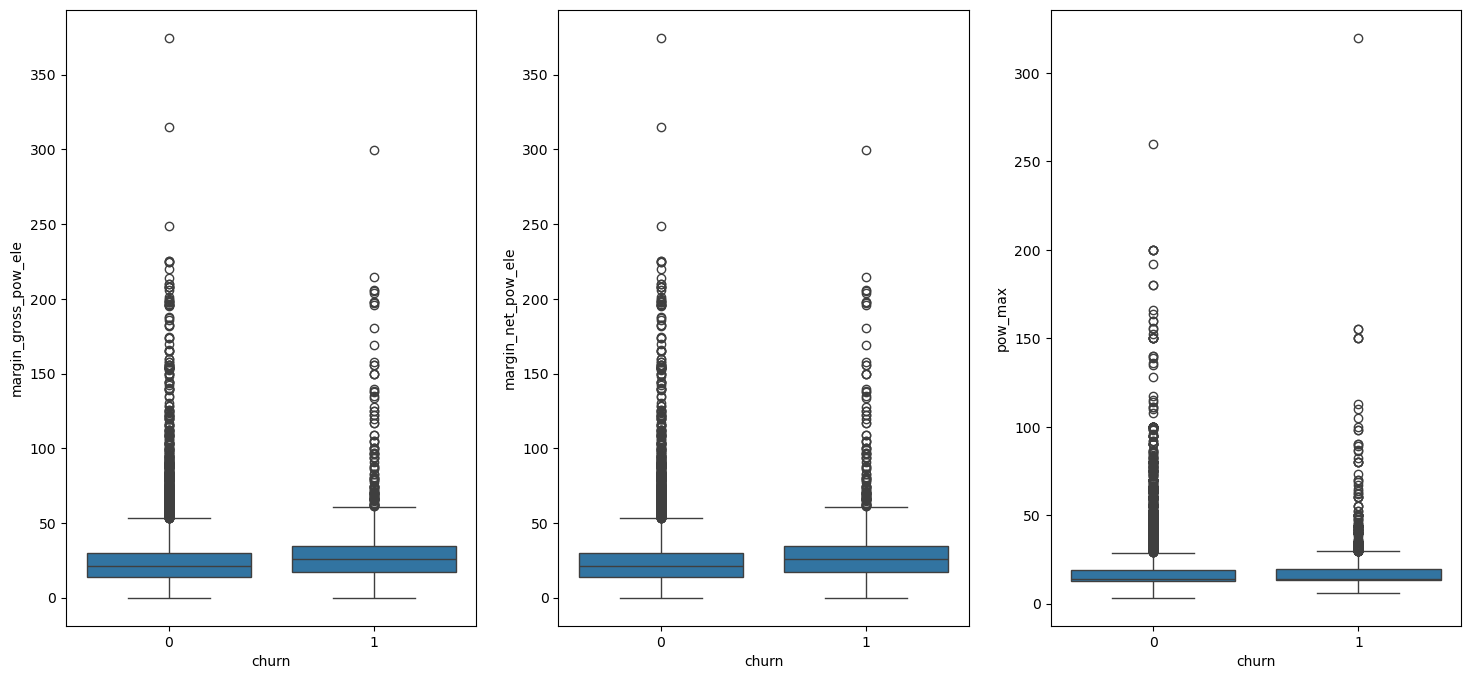

In [110]:
fig, ax = plt.subplots(ncols= 3, figsize = (18,8))
sns.boxplot(subs,y ="margin_gross_pow_ele", x = "churn", orient = "v", ax = ax[0])
sns.boxplot(subs,y="margin_net_pow_ele",x = "churn", orient = "v", ax = ax[1])
sns.boxplot(subs,y="pow_max",x = "churn", orient = "v", ax = ax[2]);

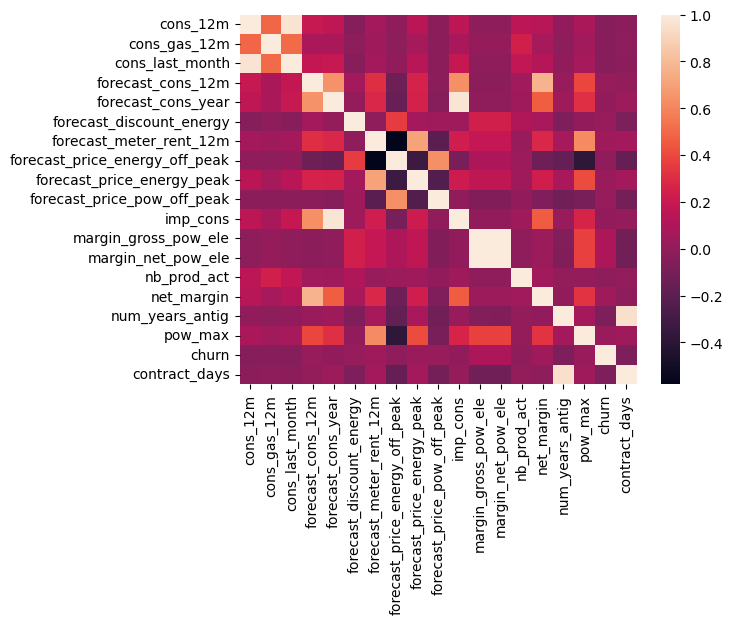

In [111]:
#check for correlation
corr = client.select_dtypes("number").corr()
sns.heatmap(corr);

In [112]:
client[["pow_max","margin_net_pow_ele"]].corr()

,pow_max,margin_net_pow_ele
pow_max,1.000000,0.373351
margin_net_pow_ele,0.373351,1.000000


## Feature Engineering
This section focuses on my feature engineering skills, my ability to prepare data for model building. I used the 'clean_data_after_eda.csv' data which is the final approved data after review.

In [114]:
ft = pd.read_csv('clean_data_after_eda.csv')
ft.head(2)

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,var_6m_price_off_peak_var,var_6m_price_peak_var,var_6m_price_mid_peak_var,var_6m_price_off_peak_fix,var_6m_price_peak_fix,var_6m_price_mid_peak_fix,var_6m_price_off_peak,var_6m_price_peak,var_6m_price_mid_peak,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,0.000131,0.000041,0.000908,2.086294,99.530517,44.235794,2.086425,99.530558,44.236702,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.000003,0.001218,0.000000,0.009482,0.000000,0.000000,0.009485,0.001218,0.000000,0


In [115]:
ft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 44 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              14606 non-null  object 
 1   channel_sales                   14606 non-null  object 
 2   cons_12m                        14606 non-null  int64  
 3   cons_gas_12m                    14606 non-null  int64  
 4   cons_last_month                 14606 non-null  int64  
 5   date_activ                      14606 non-null  object 
 6   date_end                        14606 non-null  object 
 7   date_modif_prod                 14606 non-null  object 
 8   date_renewal                    14606 non-null  object 
 9   forecast_cons_12m               14606 non-null  float64
 10  forecast_cons_year              14606 non-null  int64  
 11  forecast_discount_energy        14606 non-null  float64
 12  forecast_meter_rent_12m         

In [116]:
#Convert every date to date datatype
ft["date_activ"] = pd.to_datetime(ft["date_activ"], format='%Y-%m-%d')
ft["date_end"] = pd.to_datetime(ft["date_end"], format='%Y-%m-%d')
ft['date_modif_prod'] = pd.to_datetime(ft['date_modif_prod'],format = '%Y-%m-%d')
ft['date_renewal'] = pd.to_datetime(ft['date_renewal'],format = '%Y-%m-%d')

In [118]:
ft.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,var_6m_price_off_peak_var,var_6m_price_peak_var,var_6m_price_mid_peak_var,var_6m_price_off_peak_fix,var_6m_price_peak_fix,var_6m_price_mid_peak_fix,var_6m_price_off_peak,var_6m_price_peak,var_6m_price_mid_peak,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,0.000131,4.100838e-05,9.084737e-04,2.086294,99.530517,44.235794,2.086425,9.953056e+01,4.423670e+01,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.000003,1.217891e-03,0.000000e+00,0.009482,0.000000,0.000000,0.009485,1.217891e-03,0.000000e+00,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.000004,9.450150e-08,0.000000e+00,0.000000,0.000000,0.000000,0.000004,9.450150e-08,0.000000e+00,0
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,0.000003,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000003,0.000000e+00,0.000000e+00,0
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,0.000011,2.896760e-06,4.860000e-10,0.000000,0.000000,0.000000,0.000011,2.896760e-06,4.860000e-10,0


In [119]:
price_df = pd.read_csv('price_data (1).csv')
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
price_df.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


#### Dealing with Outliers

In [126]:
skewed_var = [
    'cons_12m', 
    'cons_gas_12m', 
    'cons_last_month',
    'forecast_cons_12m', 
    'forecast_cons_year', 
    'forecast_discount_energy',
    'forecast_meter_rent_12m', 
    'forecast_price_energy_off_peak',
    'forecast_price_energy_peak', 
    'forecast_price_pow_off_peak'
]

In [127]:
ft[skewed_var].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cons_12m,14606.0,4.223939,0.884515,0.0,3.754023,4.149727,4.610285,6.792889
cons_gas_12m,14606.0,0.779244,1.717071,0.0,0.000000,0.000000,0.000000,6.618528
cons_last_month,14606.0,2.264646,1.769305,0.0,0.000000,2.899547,3.529430,5.887169
forecast_cons_12m,14606.0,2.962177,0.683592,0.0,2.695477,3.046836,3.380716,4.918575
forecast_cons_year,14606.0,1.784610,1.584986,0.0,0.000000,2.498311,3.242231,5.243970
forecast_discount_energy,14606.0,0.050918,0.267388,0.0,0.000000,0.000000,0.000000,1.491362
forecast_meter_rent_12m,14606.0,1.517203,0.571481,0.0,1.235023,1.296555,2.120673,2.778376
forecast_price_energy_off_peak,14606.0,0.055766,0.009438,0.0,0.047796,0.058109,0.059316,0.105157
forecast_price_energy_peak,14606.0,0.020918,0.020296,0.0,0.000000,0.035085,0.040933,0.077722
forecast_price_pow_off_peak,14606.0,1.636058,0.134237,0.0,1.619163,1.656207,1.656207,1.780075


In [128]:
# Apply log 10 transformation
ft['cons_12m'] = np.log10(ft['cons_12m'] +1)
ft['cons_gas_12m'] = np.log10(ft['cons_gas_12m'] +1)
ft["cons_last_month"] = np.log10(ft["cons_last_month"] + 1)
ft["forecast_cons_12m"] = np.log10(ft["forecast_cons_12m"] +1)
ft["forecast_cons_year"] = np.log10(ft["forecast_cons_year"]+1)
ft["forecast_discount_energy"] = np.log10(ft["forecast_discount_energy"]+1)
ft["forecast_meter_rent_12m"] = np.log10(ft["forecast_meter_rent_12m"]+1)
ft["forecast_price_energy_off_peak"] = np.log10(ft["forecast_price_energy_off_peak"]+1)
ft["forecast_price_energy_peak"] = np.log10(ft["forecast_price_energy_peak"]+1)
ft["forecast_price_pow_off_peak"] = np.log10(ft["forecast_price_pow_off_peak"]+1)


In [129]:
ft[skewed_var].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cons_12m,14606.0,0.710011,0.092439,0.0,0.677061,0.711784,0.748985,0.891698
cons_gas_12m,14606.0,0.129048,0.278711,0.0,0.000000,0.000000,0.000000,0.881871
cons_last_month,14606.0,0.420992,0.310799,0.0,0.000000,0.591014,0.656044,0.838041
forecast_cons_12m,14606.0,0.587677,0.108446,0.0,0.567671,0.607116,0.641545,0.772217
forecast_cons_year,14606.0,0.350704,0.303843,0.0,0.000000,0.543858,0.627594,0.795461
forecast_discount_energy,14606.0,0.013653,0.071665,0.0,0.000000,0.000000,0.000000,0.396437
forecast_meter_rent_12m,14606.0,0.387011,0.117626,0.0,0.349282,0.361077,0.494248,0.577305
forecast_price_energy_off_peak,14606.0,0.023550,0.003892,0.0,0.020277,0.024531,0.025026,0.043424
forecast_price_energy_peak,14606.0,0.008905,0.008637,0.0,0.000000,0.014976,0.017423,0.032507
forecast_price_pow_off_peak,14606.0,0.419956,0.034065,0.0,0.418163,0.424262,0.424262,0.444057


#### Transforming Categorical Values

In [130]:
# Transform into categorical type
ft['channel_sales'] = ft['channel_sales'].astype('category')

# Let's see how many categories are within this column
ft['channel_sales'].value_counts()

channel_sales
foosdfpfkusacimwkcsosbicdxkicaua    6754
MISSING                             3725
lmkebamcaaclubfxadlmueccxoimlema    1843
usilxuppasemubllopkaafesmlibmsdf    1375
ewpakwlliwisiwduibdlfmalxowmwpci     893
sddiedcslfslkckwlfkdpoeeailfpeds      11
epumfxlbckeskwekxbiuasklxalciiuu       3
fixdbufsefwooaasfcxdxadsiekoceaa       2
Name: count, dtype: int64

In [131]:
ft = pd.get_dummies(ft, columns=['channel_sales'], prefix='channel')
ft = ft.drop(columns=['channel_sddiedcslfslkckwlfkdpoeeailfpeds', 'channel_epumfxlbckeskwekxbiuasklxalciiuu', 'channel_fixdbufsefwooaasfcxdxadsiekoceaa'])
ft.head()

,id,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,...,var_6m_price_mid_peak_fix,var_6m_price_off_peak,var_6m_price_peak,var_6m_price_mid_peak,churn,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf
0,24011ae4ebbe3035111d65fa7c15bc57,0.000000,0.758908,0.000000,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.000000,0.000000,...,44.235794,2.086425,9.953056e+01,4.423670e+01,1,False,False,True,False,False
1,d29c2c54acc38ff3c0614d0a653813dd,0.669175,0.000000,0.000000,2009-08-21,2016-08-30,2009-08-21,2015-08-31,0.515996,0.000000,...,0.000000,0.009485,1.217891e-03,0.000000e+00,0,True,False,False,False,False
2,764c75f661154dac3a6c254cd082ea7d,0.572453,0.000000,0.000000,2010-04-16,2016-04-16,2010-04-16,2015-04-17,0.429727,0.000000,...,0.000000,0.000004,9.450150e-08,0.000000e+00,0,False,False,True,False,False
3,bba03439a292a1e166f80264c16191cb,0.623252,0.000000,0.000000,2010-03-30,2016-03-30,2010-03-30,2015-03-31,0.529185,0.000000,...,0.000000,0.000003,0.000000e+00,0.000000e+00,0,False,False,False,True,False
4,149d57cf92fc41cf94415803a877cb4b,0.667080,0.000000,0.570754,2010-01-13,2016-03-07,2010-01-13,2015-03-09,0.562301,0.570754,...,0.000000,0.000011,2.896760e-06,4.860000e-10,0,True,False,False,False,False


In [132]:
# Transform into categorical type
ft['origin_up'] = ft['origin_up'].astype('category')

# Let's see how many categories are within this column
ft['origin_up'].value_counts()

origin_up
lxidpiddsbxsbosboudacockeimpuepw    7097
kamkkxfxxuwbdslkwifmmcsiusiuosws    4294
ldkssxwpmemidmecebumciepifcamkci    3148
MISSING                               64
usapbepcfoloekilkwsdiboslwaxobdp       2
ewxeelcelemmiwuafmddpobolfuxioce       1
Name: count, dtype: int64

In [133]:
ft = pd.get_dummies(ft, columns=['origin_up'], prefix='origin_up')
ft = ft.drop(columns=['origin_up_MISSING', 'origin_up_usapbepcfoloekilkwsdiboslwaxobdp', 'origin_up_ewxeelcelemmiwuafmddpobolfuxioce'])
ft.head()

,id,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,...,var_6m_price_mid_peak,churn,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,24011ae4ebbe3035111d65fa7c15bc57,0.000000,0.758908,0.000000,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.000000,0.000000,...,4.423670e+01,1,False,False,True,False,False,False,False,True
1,d29c2c54acc38ff3c0614d0a653813dd,0.669175,0.000000,0.000000,2009-08-21,2016-08-30,2009-08-21,2015-08-31,0.515996,0.000000,...,0.000000e+00,0,True,False,False,False,False,True,False,False
2,764c75f661154dac3a6c254cd082ea7d,0.572453,0.000000,0.000000,2010-04-16,2016-04-16,2010-04-16,2015-04-17,0.429727,0.000000,...,0.000000e+00,0,False,False,True,False,False,True,False,False
3,bba03439a292a1e166f80264c16191cb,0.623252,0.000000,0.000000,2010-03-30,2016-03-30,2010-03-30,2015-03-31,0.529185,0.000000,...,0.000000e+00,0,False,False,False,True,False,True,False,False
4,149d57cf92fc41cf94415803a877cb4b,0.667080,0.000000,0.570754,2010-01-13,2016-03-07,2010-01-13,2015-03-09,0.562301,0.570754,...,4.860000e-10,0,True,False,False,False,False,True,False,False


In [134]:
ft.select_dtypes("float").nunique()

cons_12m                          11065
cons_gas_12m                       2112
cons_last_month                    4751
forecast_cons_12m                 13993
forecast_cons_year                 4218
forecast_discount_energy             12
forecast_meter_rent_12m            3528
forecast_price_energy_off_peak      516
forecast_price_energy_peak          329
forecast_price_pow_off_peak          41
imp_cons                           7752
margin_gross_pow_ele               2391
margin_net_pow_ele                 2391
net_margin                        11965
pow_max                             698
var_year_price_off_peak_var        4672
var_year_price_peak_var            2694
var_year_price_mid_peak_var        1893
var_year_price_off_peak_fix         885
var_year_price_peak_fix             379
var_year_price_mid_peak_fix         374
var_year_price_off_peak            5765
var_year_price_peak                2936
var_year_price_mid_peak            2145
var_6m_price_off_peak_var          2401


In [142]:
#Extract month from date values
ft["months_activ"] = ft["date_activ"].dt.month
ft["months_to_end"] = ft["date_end"].dt.month
ft["months_modif_prod"] = ft["date_modif_prod"].dt.month
ft["months_renewal"] = ft["date_renewal"].dt.month

In [146]:
ft.drop(columns = ["date_activ", "date_end","date_modif_prod", "date_renewal"], axis = 1, inplace= True)

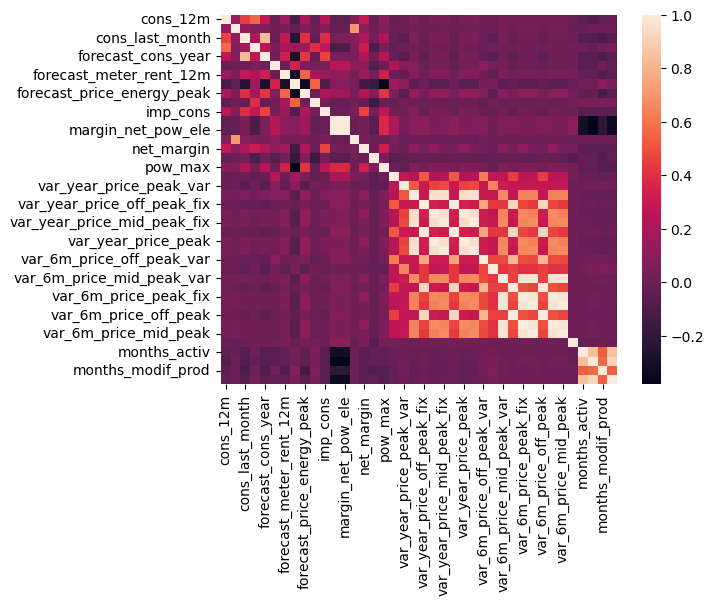

In [147]:
ft_corr = ft.select_dtypes("number").corr()
sns.heatmap(ft_corr);

## Model Building
This section focuses on building RandomForestClassifier model that will predict churn of a customer based on pre-existing features. 

I will be using the 'data_for_predictions.csv' data, which is the approved dataset after review.

In [7]:
#Importing Libraries
import warnings
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV,cross_val_score,train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


warnings.filterwarnings(action = "ignore", category = FutureWarning)
%matplotlib inline

In [3]:
#Data Importing
df = pd.read_csv("data_for_predictions.csv")
df.drop(columns = "Unnamed: 0", axis =1 , inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 63 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   id                                          14606 non-null  object 
 1   cons_12m                                    14606 non-null  float64
 2   cons_gas_12m                                14606 non-null  float64
 3   cons_last_month                             14606 non-null  float64
 4   forecast_cons_12m                           14606 non-null  float64
 5   forecast_discount_energy                    14606 non-null  float64
 6   forecast_meter_rent_12m                     14606 non-null  float64
 7   forecast_price_energy_off_peak              14606 non-null  float64
 8   forecast_price_energy_peak                  14606 non-null  float64
 9   forecast_price_pow_off_peak                 14606 non-null  float64
 10  has_gas   

In [4]:
#Horizontal split
X = df.drop(columns = ["id","churn"], axis = 1)
y = df["churn"]
print(X.shape)
print(y.shape)

(14606, 61)
(14606,)


In [5]:
#Vertical Split : 65% to the train set, 20% from training set to validation set, and 25% to test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)
print(X_val.shape)

(8763, 61)
(3652, 61)
(8763,)
(3652,)
(2191,)
(2191, 61)


In [13]:
#Resampling: Under Sampling
under_sampler = RandomUnderSampler(random_state=42)
X_train_under,y_train_under = under_sampler.fit_resample(X_train,y_train)
print(X_train_under.shape)
y_train_under.value_counts(normalize = True)

(1684, 61)


churn
0    0.5
1    0.5
Name: proportion, dtype: float64

In [14]:
#Resampling: Over Sampling
over_sampler = RandomOverSampler(random_state=42)
X_train_over,y_train_over = over_sampler.fit_resample(X_train,y_train)
print(X_train_over.shape)
y_train_over.value_counts(normalize = True)

(15842, 61)


churn
0    0.5
1    0.5
Name: proportion, dtype: float64

In [15]:
#Baseline
acc_baseline = y_train.value_counts(normalize = True).max()
print("Baseline Accuracy: ", round(acc_baseline,4))

Baseline Accuracy:  0.9039


In [16]:
#Train Model
model = RandomForestClassifier(random_state=42)
model.fit(X_train,y_train)

# Train under sampler model
model_under = RandomForestClassifier(random_state=42)
model_under.fit(X_train_under, y_train_under)

# Train under sampler model
model_over = RandomForestClassifier(random_state=42)
model_over.fit(X_train_over, y_train_over)

RandomForestClassifier(random_state=42)

In [17]:
#Evaluate models
for m in [model, model_under, model_over]:
    acc_train = m.score(X_train,y_train)
    acc_val = m.score(X_val, y_val)
    print("Training Accuracy: ",round(acc_train,4))
    print("Val Accuracy: ",round(acc_val,4))

Training Accuracy:  1.0
Val Accuracy:  0.9101
Training Accuracy:  0.7108
Val Accuracy:  0.6609
Training Accuracy:  1.0
Val Accuracy:  0.9042


model and model_over(model with oversampled set) performed similarly well while model_under(model with undersample set) performed badly. I will perform hyperparameter turning on model.

In [6]:
#Hyper Parameter
depth_hyperparameter = range(1,40,2)
train_acc = []
val_acc = []
for d in depth_hyperparameter:
    test_model = RandomForestClassifier(max_depth=d, random_state=42)
    test_model.fit(X_train,y_train)
    train_acc.append(test_model.score(X_train, y_train))
    val_acc.append(test_model.score(X_val,y_val))
print("Training Accuracy Scores: ", train_acc[:3])
print("Validation Accuracy Scores: ", val_acc[:3])

Training Accuracy Scores:  [0.9039141846399635, 0.9039141846399635, 0.9041424169804861]
Validation Accuracy Scores:  [0.9036969420356001, 0.9036969420356001, 0.9036969420356001]


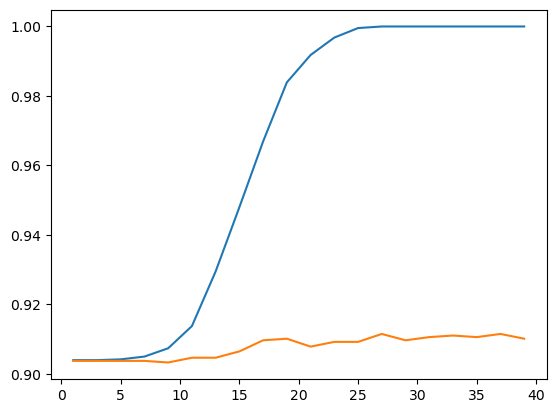

In [19]:
plt.plot(depth_hyperparameter,train_acc,label = "training")
plt.plot(depth_hyperparameter,val_acc,label = "Validation")

In [20]:
test_model = RandomForestClassifier(max_depth=5, random_state=42)
test_model.fit(X_train,y_train)

RandomForestClassifier(max_depth=5, random_state=42)

In [21]:
test_acc = test_model.score(X_test,y_test)
print("Test Accuracy: ",round(test_acc,3))

Test Accuracy:  0.9


In [12]:
predictions = test_model.predict(X_test)
tn, fp, fn, tp = metrics.confusion_matrix(y_test, predictions).ravel()
y_test.value_counts()

churn
0    3286
1     366
Name: count, dtype: int64

In [13]:
print(f'True positives: {tp}')
print(f'False positives: {fp}')
print(f'True negatives: {tn}')
print(f"False negatives: {fn}\n")

print(f'Accuracy: {round(metrics.accuracy_score(y_test, predictions),5)}')
print(f'Precision: {round(metrics.precision_score(y_test, predictions),5)}')

True positives: 19
False positives: 5
True negatives: 3281
False negatives: 347

Accuracy: 0.90361
Precision: 0.79167


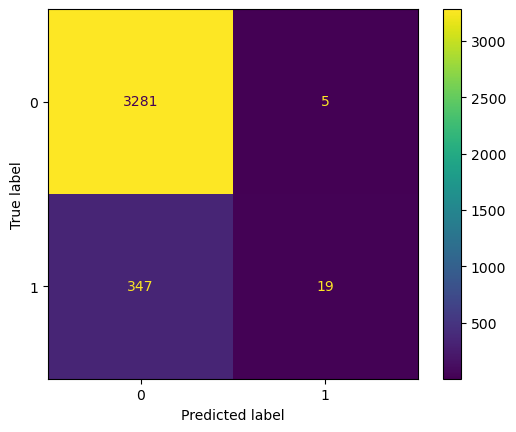

In [9]:
ConfusionMatrixDisplay.from_estimator(test_model,X_test,y_test)

In [10]:
feature_importances = pd.DataFrame({"features": X_train.columns,
                                   "importance": test_model.feature_importances_
}).sort_values(by = "importance", ascending = True).reset_index()

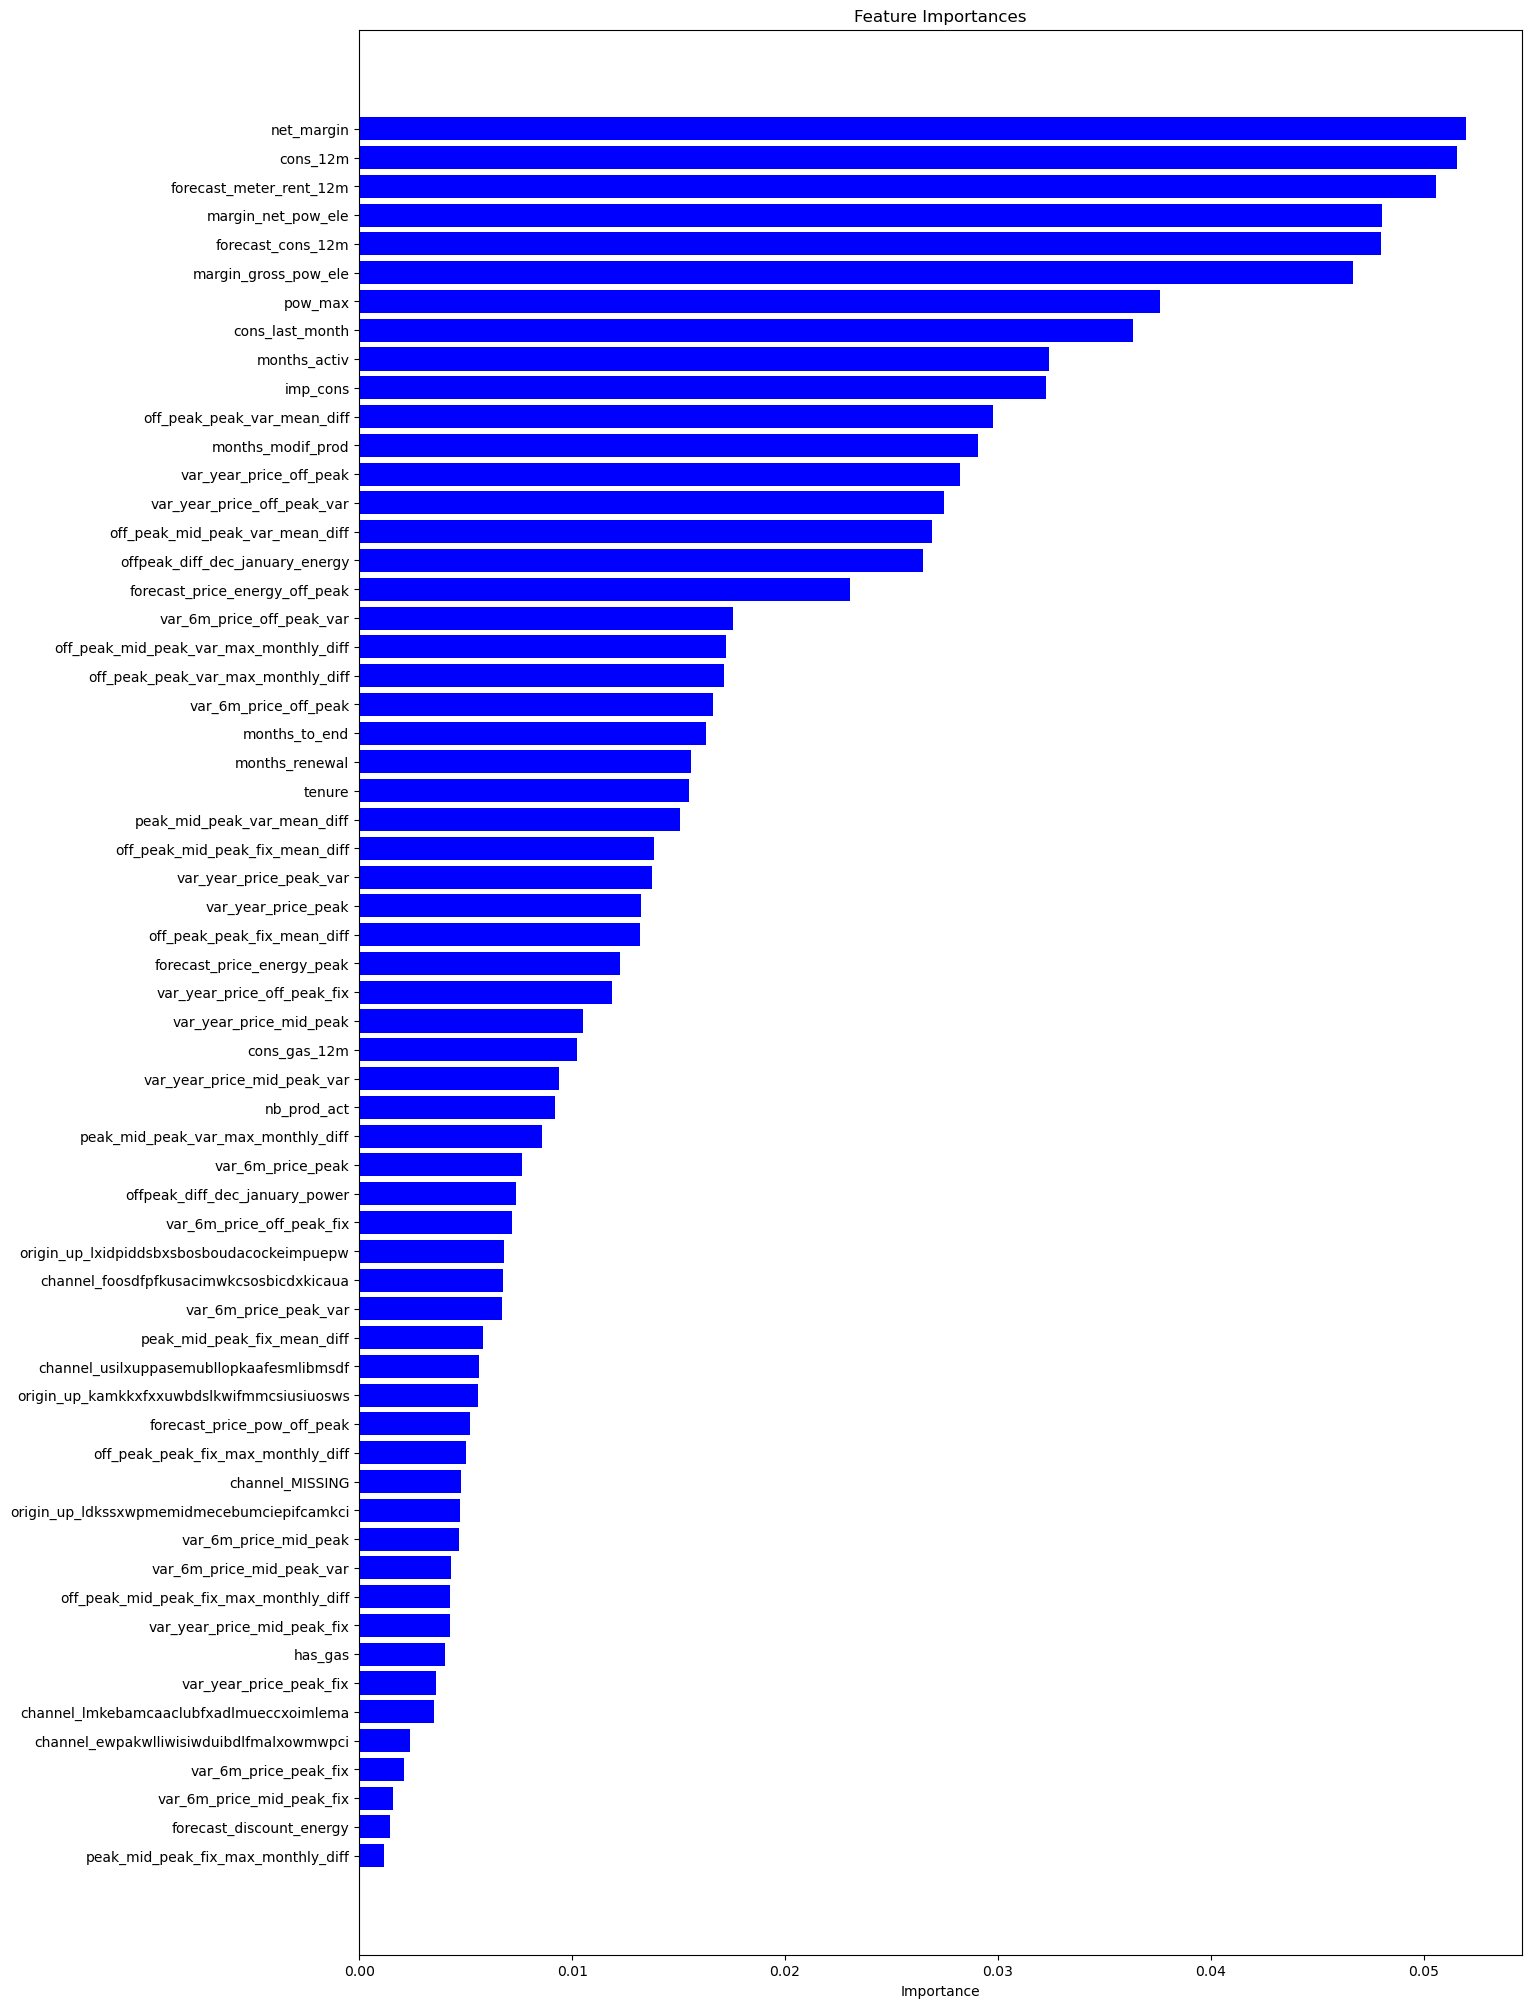

In [11]:
plt.figure(figsize=(15,25))
plt.title("Feature Importances")
plt.barh(range(len(feature_importances)), 
         feature_importances["importance"], 
         color = "b",
         align = "center")
plt.yticks(range(len(feature_importances)), feature_importances["features"])
plt.xlabel("Importance")
plt.show()

#### Saving Model

In [15]:
#Save model into pickle
with open("churn_model","wb") as file:
    pickle.dump(test_model,file)

In [17]:
"""
Create a function that will:
1. Recieve a csv file path and model path
2. Create a prediction 
3. Add prediction and prediction probability to existing X_test file
4. Save the X_test into the device as a csv_file.
"""
def make_prediction(data_filepath, model_filepath, output_csv_title):
    #Load file
    X_test = pd.read_csv(data_filepath)
    #Load Model
    with open(model_filepath,"rb") as file:
        model = pickle.load(file)
    #Make prediction
    proba_prediction = model.predict(X_test)
    probabilities = proba_predictions[:,1]
    X_test = X_test.reset_index()
    X_test.drop(columns = "index", inplace = True)
    #Save to csv
    X_test['Churn'] = proba_prediction.tolist()
    X_test['Churn_probability'] = probabilities.tolist()
    X_test.to_csv(output_csv_title)

## Conclusion: 
- After analysis and model building, it is clear that the hypothesis is false. Price sensitivity isn't the reason for churn; net_margin, Cons_12m, and forecast_cons_12m are the major factors that influencies churn rate in this model.

- Time seems to be an influential factor, especially the number of months they have been active, their tenure and the number of months since they updated their contract

- Price sensitivity features are scattered around but are not the main driver for a customer churning.